# Tree detection inference

In [1]:
# Import required libraries
from pathlib import Path
import torch

from tree_detection_framework.constants import DATA_FOLDER
from tree_detection_framework.detection.detector import DeepForestDetector
from tree_detection_framework.detection.models import DeepForestModule
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Define constants
The behavior of this notebook can be changed by adjusting these values.

In [2]:
# The path to a folder of raster images, e.g. orthomosaics stor
RASTER_FOLDER_PATH = Path(DATA_FOLDER, "emerald-point-ortho")
# Prediction file path
OUTPUT_PREDICTIONS_FILE_PATH = Path(
    DATA_FOLDER, "emerald-point-ortho-deep-forest-predictions.gpkg"
)
# The size of the chips in pixels
CHIP_SIZE = 512
# The stride between chips in pixels
CHIP_STRIDE = 384
# The spatial resolution that the data is sampled to in meters/pix
OUTPUT_RESOLUTION = 0.2
# The number of samples in a batch
BATCH_SIZE = 4

# How many tiles to show
N_VIS_TILES = 3

# Setup the parameters dictionary
MODEL_PARAMS = {
    "backbone": "retinanet",
    "num_classes": 1,
}
# The device to use for inference, GPU or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Create a dataloader to generate samples

In [3]:
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    output_resolution=OUTPUT_RESOLUTION,
    batch_size=BATCH_SIZE,
)

2024-11-07 20:26:39,930 - INFO - Units = Units.PIXELS
2024-11-07 20:26:39,930 - INFO - Stride = 384


Show example samples

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


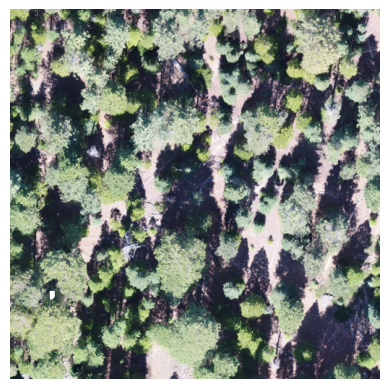

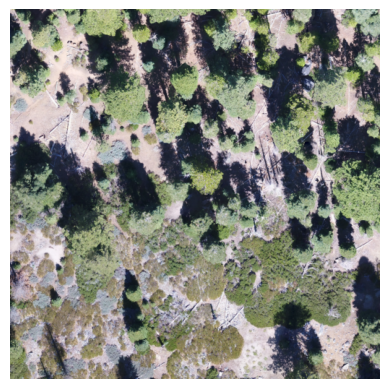

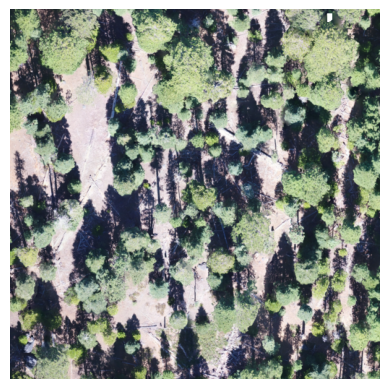

In [4]:
visualize_dataloader(dataloader, n_tiles=N_VIS_TILES)

Create a DeepForest detector model

In [5]:
# This model uses pretrained weights from DeepForest
df_module = DeepForestModule(MODEL_PARAMS).to(DEVICE)
df_detector = DeepForestDetector(df_module)

Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/ofo-share/repos-david/tree-detection-framework/tree_detection_framework/detection/models.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(tor

Generate predictions for each tile in the dataloader

In [6]:
outputs = df_detector.predict(dataloader)

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. 

Plot the predictions for all overlapping tiles colored by the prediction confidence

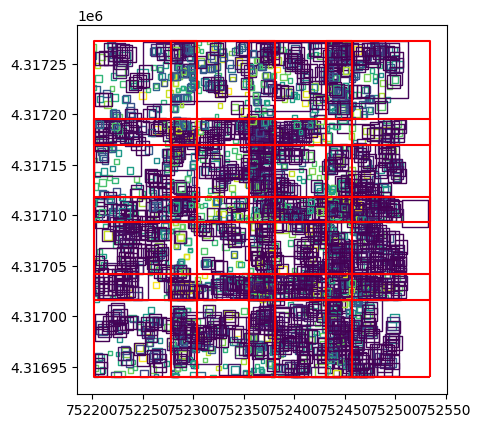

<Axes: >

In [7]:
outputs.plot(visualization_column="score", bounds_color="r")

Run nonmax suppression and across all the tiles

In [8]:
NMS_outputs = multi_region_NMS(outputs, confidence_column="score")

2024-11-07 20:27:03,076 - INFO - Bound have overlap, running across-region NMS


Show the result again after running NMS

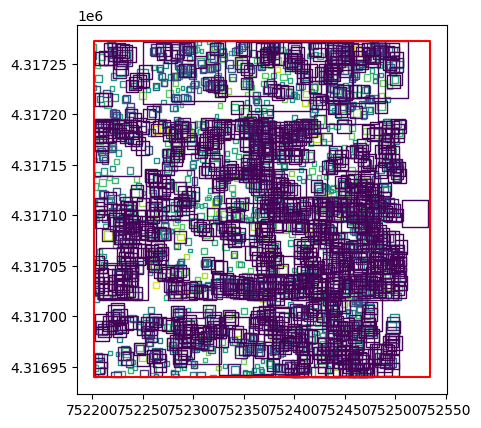

<Axes: >

In [9]:
NMS_outputs.plot(visualization_column="score", bounds_color="r")

Save out the predictions to a geospatial file

In [10]:
NMS_outputs.save(OUTPUT_PREDICTIONS_FILE_PATH)

2024-11-07 20:27:04,023 - INFO - Created 2,623 records
